In [2]:
import sys
import importlib
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import src.utilities.utils  as u
import src.utilities.model_utils  as mu
import src.utilities.plots_utils as pu

import h5py
import torch

In [2]:
path = "./datasets/sys_3_1__1/"
data, imgs, missing_folders, failed_folders = u.load_all_data(path, load_images=True)
data.keys()

  - datapoint_00035: contains ['cut_0.png']
  - datapoint_00191: contains ['cut_0.png']
  - datapoint_00195: empty folder
  - datapoint_00361: empty folder
  - datapoint_00569: empty folder
  - datapoint_00940: empty folder
  - datapoint_00985: empty folder
  - datapoint_01159: empty folder
  - datapoint_01613: empty folder
  - datapoint_01711: empty folder
  ... and 10 more
Total folders found: 5000, folders with data.npz: 4980, missing: 20
Loading 4980 datapoints from ./datasets/sys_3_1__1/.
First file: ./datasets/sys_3_1__1/datapoint_00000\data.npz, Last file: ./datasets/sys_3_1__1/datapoint_04999\data.npz
Starting to load and preprocess images...


dict_keys(['C_tilde_DD', 'C_DG', 'geometry', 'tc_meV', 'v_offset', 'x_voltage', 'y_voltage', 'alpha', 'E_c', 'cuts'])

In [3]:
imgs
context = u.create_context(data)
outputs = u.create_outputs(data) # TODO: make sure that you use E_c nor inv(C_tilde_DD)

<KeysViewHDF5 ['inputs', 'outputs', 'targets']>


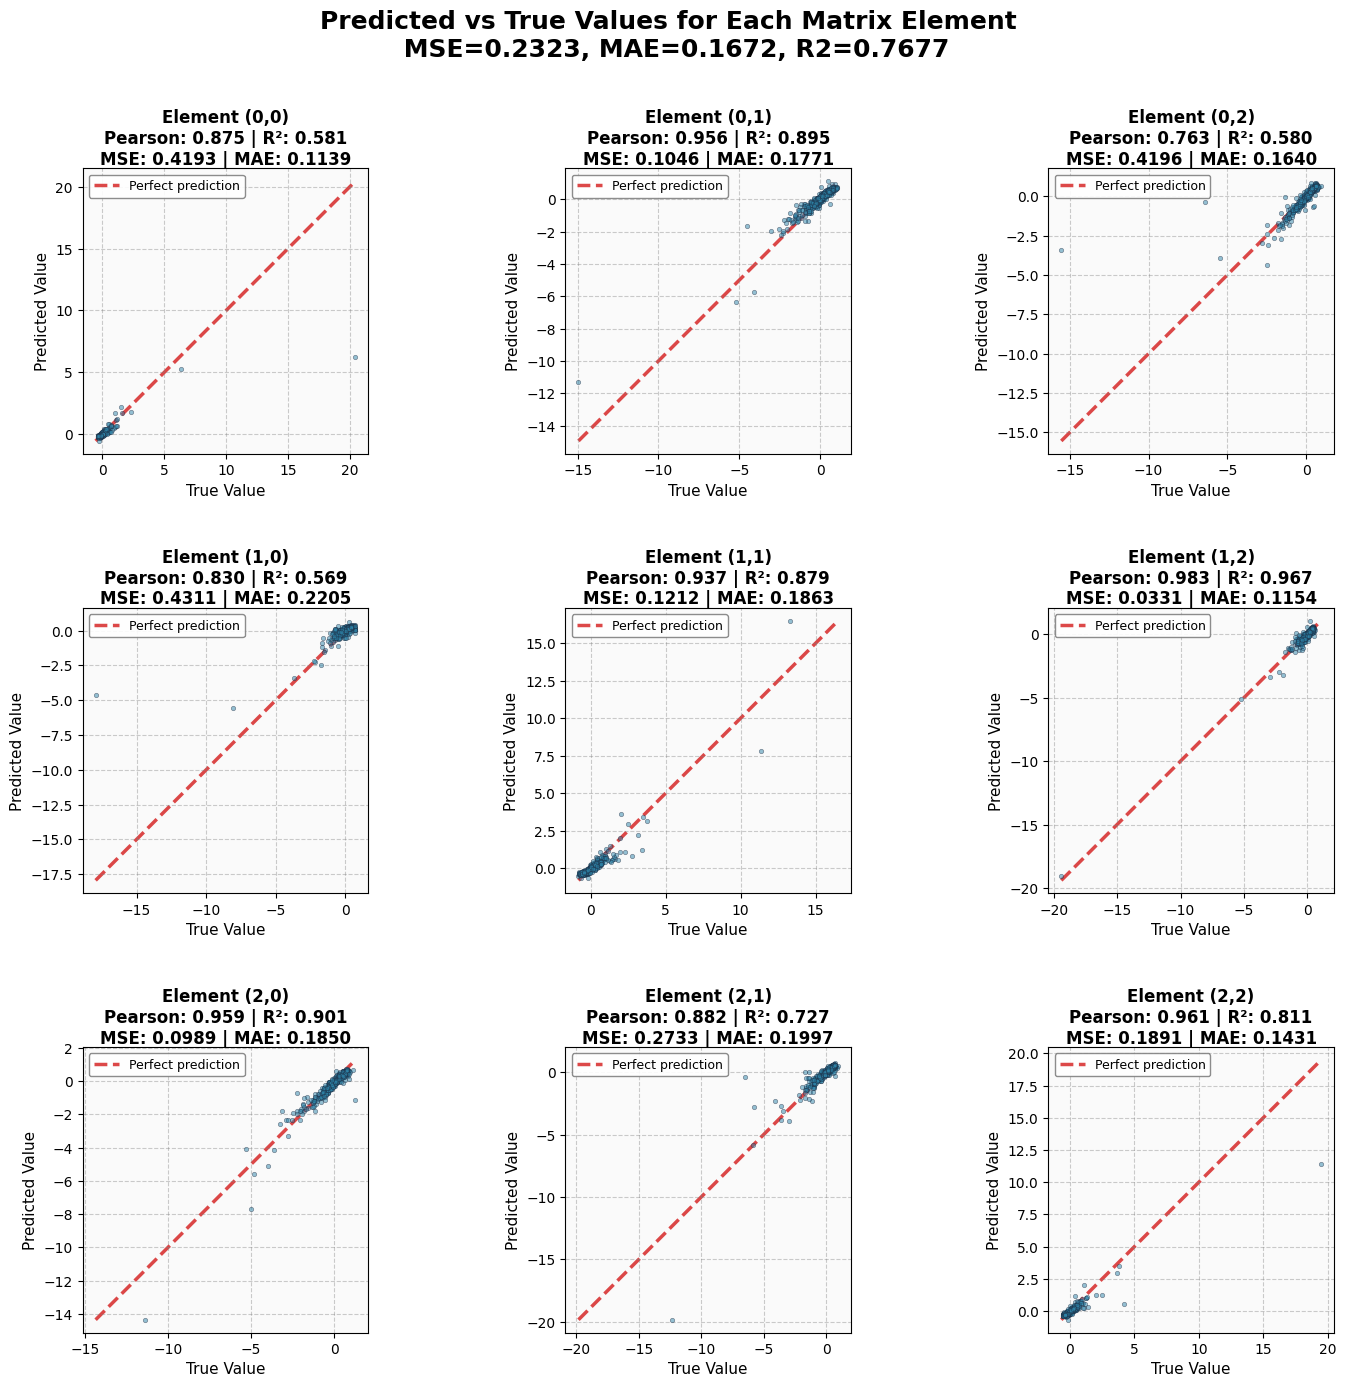

In [3]:
%matplotlib inline
model_load_path = 'results/MBArch_2026-01-19_23-55-43'


with h5py.File(model_load_path + '/predictions.h5', 'r') as f:
    print(f.keys())
    inputs = f['inputs'][:]
    outputs = f['outputs'][:]
    targets = f['targets'][:]
    

pu.plot_prediction_vs_true_matrix_elements(targets, outputs, save_dir=None, figsize_per_subplot=(5, 5), alpha=0.5, s=10, plotname='prediction_vs_true_elementwise')

input_test = inputs[0]

In [20]:
outputs[np.where(outputs[:, 0] > 5)].squeeze()[0]

array([ 5.250082  , -1.8249516 , -0.02920038, -5.593475  , -0.07276099,
        0.3689869 , -7.6987605 ,  0.7062593 , -0.10448712], dtype=float32)

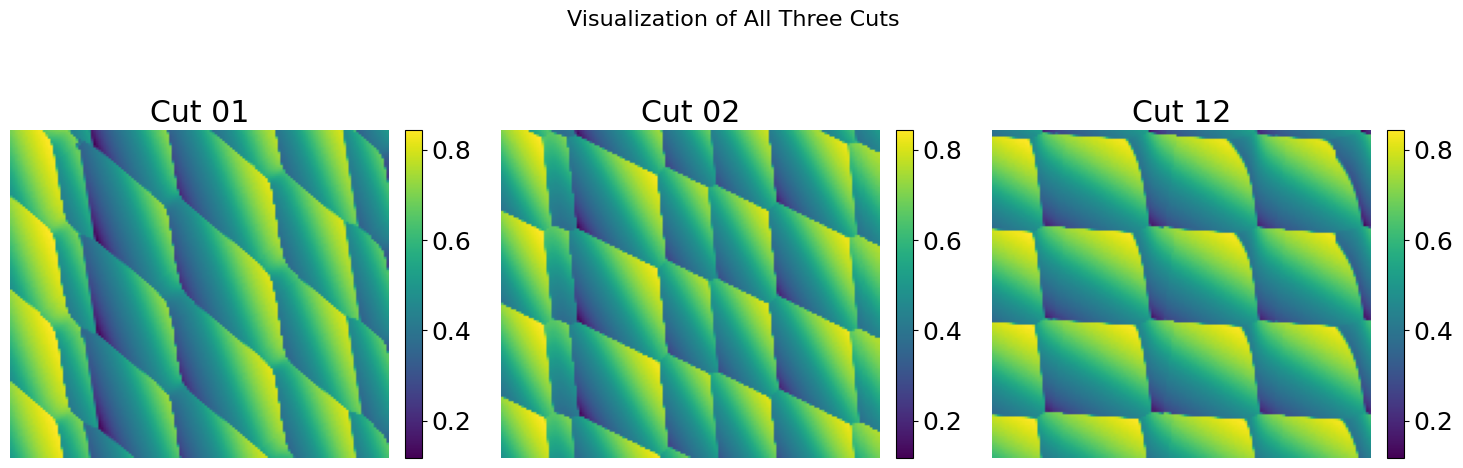

In [16]:
cut_01 = inputs[np.where(outputs[:, 0] > 5)].squeeze()[0][0]
cut_02 = inputs[np.where(outputs[:, 0] > 5)].squeeze()[0][1]
cut_12 = inputs[np.where(outputs[:, 0] > 5)].squeeze()[0][2]


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cuts = [cut_01, cut_02, cut_12]
titles = ['Cut 01', 'Cut 02', 'Cut 12']

for i, (cut, ax, title) in enumerate(zip(cuts, axs, titles)):
    im = ax.imshow(cut, aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Visualization of All Three Cuts", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()